In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler

In [3]:
from sqlite3 import connect

In [4]:
conn = connect('stocks.db')

In [5]:
df = pd.read_sql('SELECT * FROM alltickers', conn)
df.head()

,ticker,date,open,high,low,close,adjClose,volume,dailyreturn
0,AAPL,2022-09-08,154.640,156.35,152.68,154.46,154.46,83851495,-0.009618
1,AAPL,2022-09-07,154.825,156.67,153.61,155.96,155.96,87450049,0.009254
2,AAPL,2022-09-06,156.470,157.09,153.69,154.53,154.53,73607839,-0.008215
3,AAPL,2022-09-02,159.750,160.36,154.97,155.81,155.81,76910050,-0.013611
4,AAPL,2022-09-01,156.640,158.42,154.67,157.96,157.96,74118439,0.004707


In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [7]:
def load_data(company, start, end):
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.ticker == company, :]
    dataframe = dataframe.loc[(dataframe['date'] > start) & (dataframe['date'] < end), :]
    dataframe = dataframe.rename(columns = {'close': 'Close'})
    return dataframe

In [8]:
COMPANY = 'AAPL'
START_DATE = dt.datetime(2018,1,1)
END_DATE = dt.datetime(2022,6,1)
START_DATE_TEST = END_DATE

In [9]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [11]:
len(scaled_data)

1111

In [72]:
scaled_data[0:60,0]

array([0.77352565, 0.77898782, 0.73897757, 0.71671935, 0.7156269 ,
       0.73440303, 0.69671418, 0.6950756 , 0.71876768, 0.77625679,
       0.75099426, 0.76171378, 0.73064779, 0.75754889, 0.81223862,
       0.79551081, 0.83115134, 0.82766926, 0.89082536, 0.84617223,
       0.83579422, 0.83367755, 0.87457543, 0.82630374, 0.82787408,
       0.86938643, 0.86194417, 0.89355639, 0.8990868 , 0.9002475 ,
       0.88433908, 0.88584107, 0.92073056, 0.90202276, 0.88898185,
       0.91861399, 0.93261077, 0.9304942 , 0.9525476 , 0.97562521,
       0.94742683, 0.94947516, 0.97105068, 0.97917564, 0.95623461,
       0.95022621, 0.94578826, 0.91943338, 0.9099429 , 0.88645564,
       0.87689682, 0.85395579, 0.84692328, 0.81619869, 0.78567892,
       0.81374072, 0.83961771, 0.86986431, 0.8322438 , 0.8449433 ])

In [12]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [14]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [15]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
33/33 [==============================] - 7s 19ms/step - loss: 0.0336
Epoch 2/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0048
Epoch 3/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0038
Epoch 4/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0035
Epoch 5/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0036
Epoch 6/25
33/33 [==============================] - 0s 15ms/step - loss: 0.0030
Epoch 7/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 8/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0029
Epoch 9/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 10/25
33/33 [==============================] - 0s 14ms/step - loss: 0.0027
Epoch 11/25
33/33 [==============================] - 0s 15ms/step - loss: 0.0027
Epoch 12/25
33/33 [==============================] - 0s 15ms/step - loss: 0.0024
Epoch 13/25
33/33 [==================

In [36]:
test_data = load_data(company = COMPANY,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\927232319.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


In [37]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

4/4 [==============================] - 0s 15ms/step


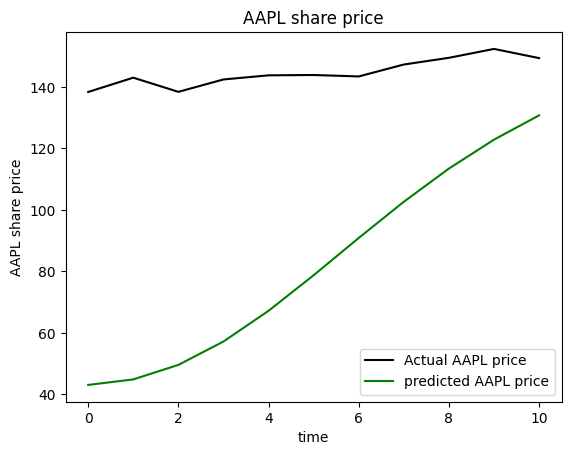

In [18]:
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [64]:
len(predicted_prices)

68

In [52]:
test_data = load_data(company = "AAPL",
                      start = START_DATE_TEST,
                      end = dt.datetime.now())
print(test_data['date'].values)

['2022-09-08T00:00:00.000000000' '2022-09-07T00:00:00.000000000'
 '2022-09-06T00:00:00.000000000' '2022-09-02T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2022-08-31T00:00:00.000000000'
 '2022-08-30T00:00:00.000000000' '2022-08-29T00:00:00.000000000'
 '2022-08-26T00:00:00.000000000' '2022-08-25T00:00:00.000000000'
 '2022-08-24T00:00:00.000000000' '2022-08-23T00:00:00.000000000'
 '2022-08-22T00:00:00.000000000' '2022-08-19T00:00:00.000000000'
 '2022-08-18T00:00:00.000000000' '2022-08-17T00:00:00.000000000'
 '2022-08-16T00:00:00.000000000' '2022-08-15T00:00:00.000000000'
 '2022-08-12T00:00:00.000000000' '2022-08-11T00:00:00.000000000'
 '2022-08-10T00:00:00.000000000' '2022-08-09T00:00:00.000000000'
 '2022-08-08T00:00:00.000000000' '2022-08-05T00:00:00.000000000'
 '2022-08-04T00:00:00.000000000' '2022-08-03T00:00:00.000000000'
 '2022-08-02T00:00:00.000000000' '2022-08-01T00:00:00.000000000'
 '2022-07-29T00:00:00.000000000' '2022-07-28T00:00:00.000000000'
 '2022-07-27T00:00:00.000

In [46]:
def draw_stock_trade(COMPANY):
    test_data = load_data(company = COMPANY,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())

    actual_prices = test_data['Close'].values

    total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.transform(model_inputs)
    x_test = []
    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
    plt.plot(predicted_prices, color= 'green', label=f"predicted {COMPANY} price")
    plt.title(f"{COMPANY} share price")
    plt.xlabel("time")
    plt.ylabel(f"{COMPANY} share price")
    plt.legend()
    plt.show()

In [53]:
def get_stock_data(COMPANY):
    test_data = load_data(company = COMPANY,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())
    actual_prices = test_data['Close'].values

    total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.transform(model_inputs)
    x_test = []
    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)
    dateList = test_data['date'].values
    res = []
    for i in range(len(dateList)):
        temp = [COMPANY, dateList[i], predicted_prices[i], actual_prices[i]]
        res.append(temp)
    return res

In [54]:
test = get_stock_data("AAPL")

4/4 [==============================] - 0s 18ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


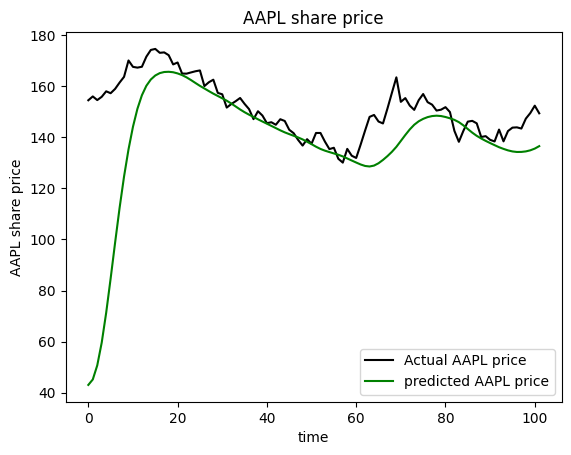

In [55]:

plt.plot([t[3] for t in test], color='black', label=f"Actual {COMPANY} price")
plt.plot([t[2] for t in test], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [56]:
companyList = df['ticker'].unique()

In [57]:
companyList

array(['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'GOOG', 'BRK.B', 'UNH',
       'JNJ', 'XOM', 'PG', 'META', 'JPM', 'NVDA', 'V', 'HD', 'CVX',
       'ABBV', 'MA', 'PFE', 'LLY', 'PEP', 'KO', 'BAC', 'MRK', 'COST',
       'TMO', 'AVGO', 'WMT', 'DIS', 'MCD', 'ABT', 'DHR', 'CSCO', 'VZ',
       'ACN', 'NEE', 'WFC', 'BMY', 'TXN', 'CRM', 'PM', 'CMCSA', 'QCOM',
       'LIN', 'ADBE', 'CVS', 'COP', 'UNP', 'NKE', 'AMGN', 'RTX', 'UPS',
       'LOW', 'HON', 'T', 'INTC', 'INTU', 'IBM', 'MDT', 'AMD', 'ELV',
       'MS', 'SPGI', 'SCHW', 'AMT', 'GS', 'PYPL', 'NFLX', 'ORCL', 'LMT',
       'SBUX', 'ADP', 'DE', 'BLK', 'CAT', 'C', 'CI', 'AXP', 'MDLZ', 'PLD',
       'SO', 'TMUS', 'DUK', 'GILD', 'NOW', 'MMC', 'CB', 'REGN', 'MO',
       'ADI', 'AMAT', 'BA', 'VRTX', 'TJX', 'PGR', 'TGT', 'GE', 'ZTS',
       'NOC', 'SYK', 'ISRG', 'BDX', 'BRK-B'], dtype=object)

In [61]:
def get_all_stock_data(companyList):
    res = []
    for company in companyList:
        res += get_stock_data(company)
    return res

In [60]:
conn.close()

In [62]:
temp = get_all_stock_data(companyList)

1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/3 [=========>....................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


4/4 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/3 [=========>....................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 14ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 11ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 14ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 14ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 14ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/3 [=========>....................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 14ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 14ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/3 [=========>....................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


2/2 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_39040\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


In [ ]:

conn = connect('new_lstm_prediction.db')
for t in temp:
    pd.read_sql('INSERT * FROM alltickers', conn)